In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

### Read Synergy + CTG Data

In [8]:
s_df = pd.read_csv('nba_offense_plus_ctg.csv')
s_df.shape

(2843, 62)

Filter in players with 200+ playtype possessions

In [9]:
# s_df = s_df[s_df['Overall_Poss'] >= 200]
# s_df.shape

### Read BBR Data

In [10]:
bbr_df = pd.read_csv('bbr_nba_stats.csv')

In [11]:
mp_filter = 400
bbr_df = bbr_df[bbr_df['mp'] >= 400]
bbr_df.shape

(1973, 39)

In [12]:
bbr_df['mp'].min()

402

### Merge Synergy Data & BBR Data

In [13]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [14]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [15]:
synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot',
                     'nahshonhyland': 'boneshyland',
                     'derrickwaltonjr': 'derrickwalton',
                     'ishmailwainright': 'ishwainright',
                     'johnnyobryantiii': 'johnnyobryant'}

In [16]:
s_df['Player_Alt'] = s_df['Player_Alt']\
                     .apply(lambda x: synergy_name_dict.get(x, x))

In [17]:
df = s_df.merge(bbr_df, how='right', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'Season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(1973, 102)

In [18]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(1973, 3)

## Clustering

### Functions

In [19]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 12))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 11, color='red', linestyle='--')
    plt.xlabel('Number of Components (c)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Results')

In [20]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                affinity='nearest_neighbors', 
                                random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method Showing the Optimal k')

### Define Weight Columns

In [21]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 
             'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [22]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [23]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [24]:
weights = playtype_weights + shottype_weights + situation_weights 
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

### Check Correlations Among Weights

Text(0.5, 1.0, 'Correlations Among Weights in NBA (2017-2022)')

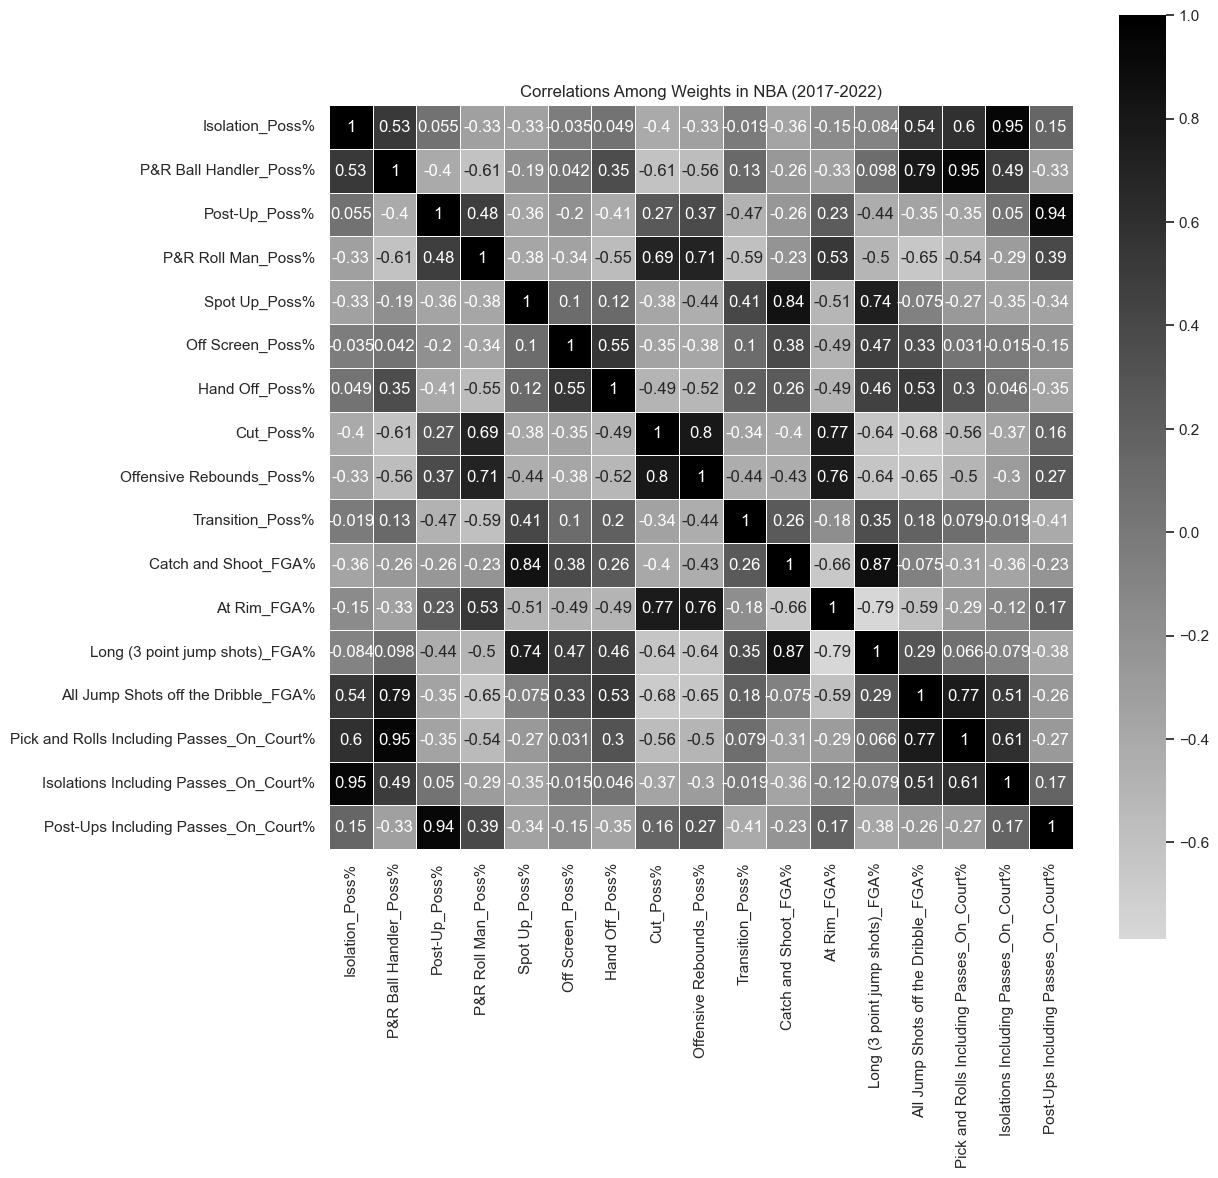

In [25]:
figsize(12, 8)
corr = df[weights].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,
            square=True, annot=True, linewidths=.5)
plt.title('Correlations Among Weights in NBA (2017-2022)')

### Reduce Dimensions with PCA

In [26]:
X = df[weights].copy()

Determine how many components reduce down to via PCA

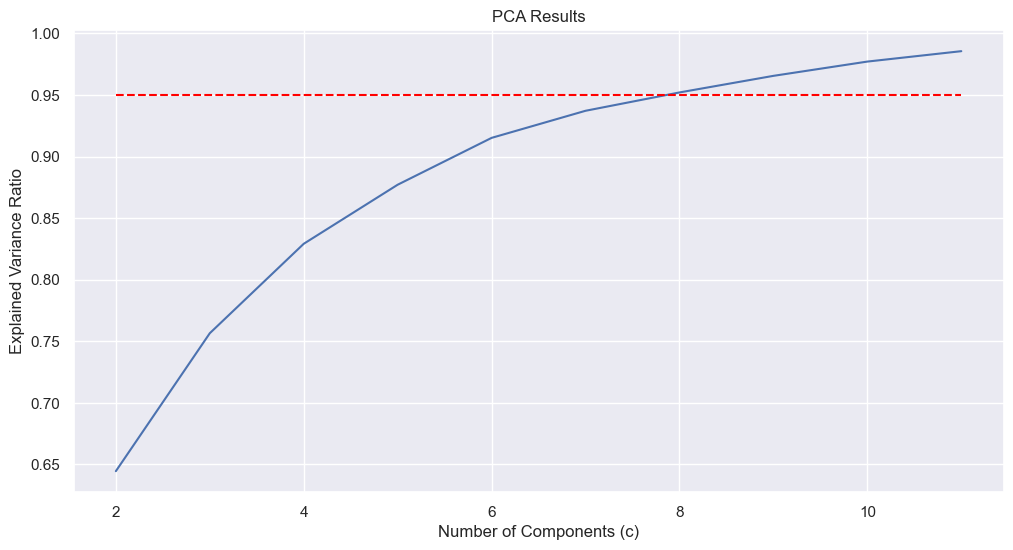

In [27]:
figsize(12, 6)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
# pre_pca_pipe = StandardScaler()
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choosse 8

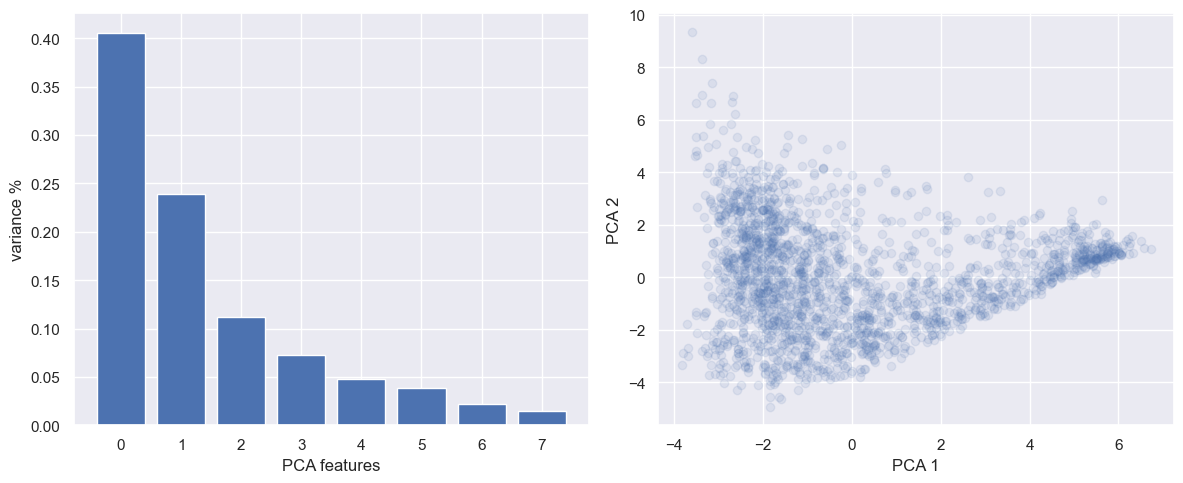

In [28]:
n_components = 8

pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=n_components)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [29]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

### Choose Optimal K

Determine # of clusters using silhouette score method

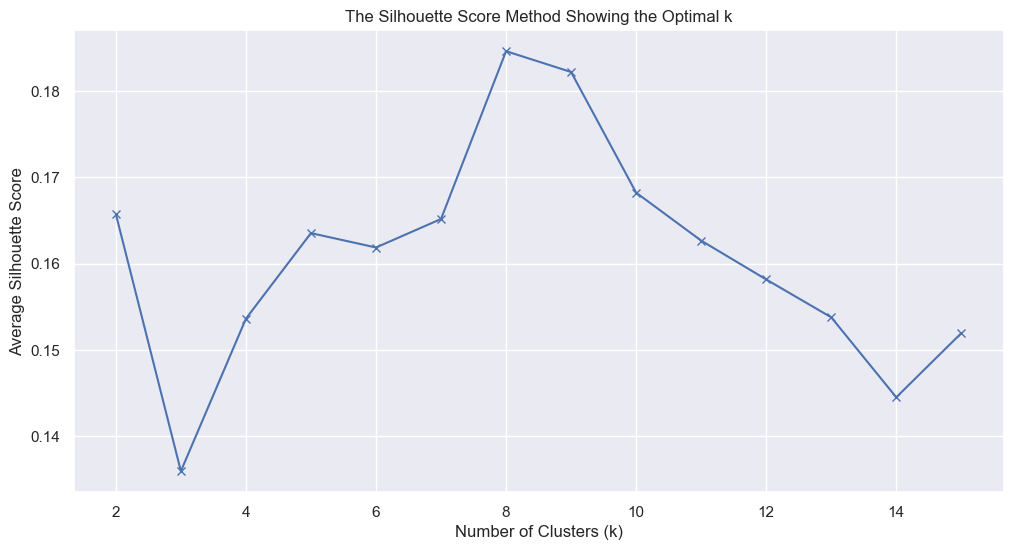

In [30]:
figsize(12, 6)
plot_silhouette_score(X_transformed)

### Clustering

In [31]:
# Choose k = 8
n_clusters = 8

sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors', 
                        random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, 
                                                  df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    673
1    569
2    152
3    224
4    133
5     46
6     74
7    102
Name: Player, dtype: int64

## Results

### Functions

In [32]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [33]:
def show_cluster_res(df, cluster_col, weights=weights):
    cluster_res = df.groupby(cluster_col)[['usg_pct', 'obpm'] + weights]\
                    .mean().sort_values('obpm', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
    for col in cluster_res.columns:
        if '%' in col or 'Rt' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

### Overview

In [34]:
show_cluster_res(df, 'player_cluster')

0       1       2       3  \
player_cluster                                  4       2       6       7   
usg_pct                                     27.3%   23.5%   15.0%   19.2%   
obpm                                         2.70    1.44    0.08   -0.10   
Isolation_Poss%                            18.60%   5.07%   0.62%   2.42%   
P&R Ball Handler_Poss%                     26.53%   1.58%   0.00%  12.24%   
Post-Up_Poss%                               6.30%  24.39%   8.17%   0.92%   
P&R Roll Man_Poss%                          2.15%  18.47%  21.90%   0.69%   
Spot Up_Poss%                              15.85%  15.19%   3.04%  29.58%   
Off Screen_Poss%                            4.25%   1.99%   0.00%  20.97%   
Hand Off_Poss%                              4.74%   0.65%   0.00%   9.33%   
Cut_Poss%                                   3.17%  12.20%  28.99%   4.33%   
Offensive Rebounds_Poss%                    2.39%  10.93%  28.91%   1.22%   
Transition_Poss%                           16.01%   9.53%   8.37%  18.29%   
Catch and Shoot_FGA%                       18.98%  22.56%   2.15%  48.16%   
At Rim_FGA%                                32.83%  42.87%  79.72%  19.55%   
Long (3 point jump shots)_FGA%             34.41%  19.92%   1.13%  58.98%   
All Jump Shots off the Dribble_FGA%        30.94%   6.17%   0.37%  24.27%   
Pick and Rolls Including Passes_On_Court%  14.82%   0.64%   0.00%   4.79%   
Isolations Including Passes_On_Court%       7.14%   1.56%   0.12%   0.76%   
Post-Ups Including Passes_On_Court%         2.76%   8.04%   1.66%   0.26%   
#                                             133     152      74     102   

                                                4       5       6       7  
player_cluster                                  1       3       5       0  
usg_pct                                     20.9%   16.8%   17.5%   16.4%  
obpm                                        -0.44   -0.62   -0.74   -1.36  
Isolation_Poss%                             7.17%   1.16%   0.95%   2.68%  
P&R Ball Handler_Poss%                     36.20%   0.13%  11.13%   7.63%  
Post-Up_Poss%                               0.71%   6.19%   0.02%   2.84%  
P&R Roll Man_Poss%                          0.23%  28.84%   0.78%   4.56%  
Spot Up_Poss%                              23.64%  15.78%  29.38%  39.05%  
Off Screen_Poss%                            3.71%   0.24%  12.92%   3.58%  
Hand Off_Poss%                              6.89%   0.12%  22.85%   4.39%  
Cut_Poss%                                   2.52%  22.37%   4.74%   8.74%  
Offensive Rebounds_Poss%                    1.31%  14.76%   1.08%   5.40%  
Transition_Poss%                           17.61%  10.41%  16.15%  21.12%  
Catch and Shoot_FGA%                       25.33%  22.83%  49.19%  42.06%  
At Rim_FGA%                                28.98%  54.59%  18.85%  34.90%  
Long (3 point jump shots)_FGA%             39.59%  18.62%  61.08%  46.72%  
All Jump Shots off the Dribble_FGA%        31.84%   1.80%  25.32%  12.41%  
Pick and Rolls Including Passes_On_Court%  15.81%   0.05%   4.10%   2.58%  
Isolations Including Passes_On_Court%       2.25%   0.27%   0.27%   0.71%  
Post-Ups Including Passes_On_Court%         0.24%   1.51%   0.01%   0.75%  
#                                             569     224      46     673

- Ballhandler: 4 & 1
- Big: 2 & 6 & 3
- Wing: 7 & 5 & 0

In [35]:
cluster_dict = {4: 'Ballhandler', 1: 'Ballhandler',
                2: 'Big', 6: 'Big', 3: 'Big',
                7: 'Wing', 5: 'Wing', 0: 'Wing'}

In [36]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [37]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [38]:
show_cluster_res(df, 'player_cluster')\
.style.applymap(color_cluster_pandas)

### Observations

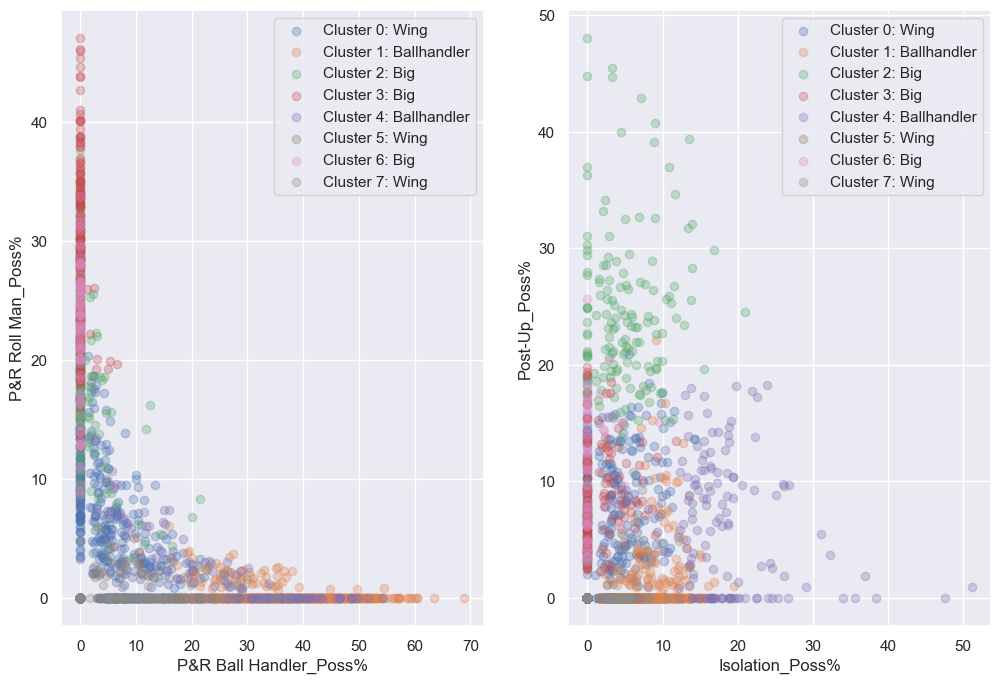

In [39]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)

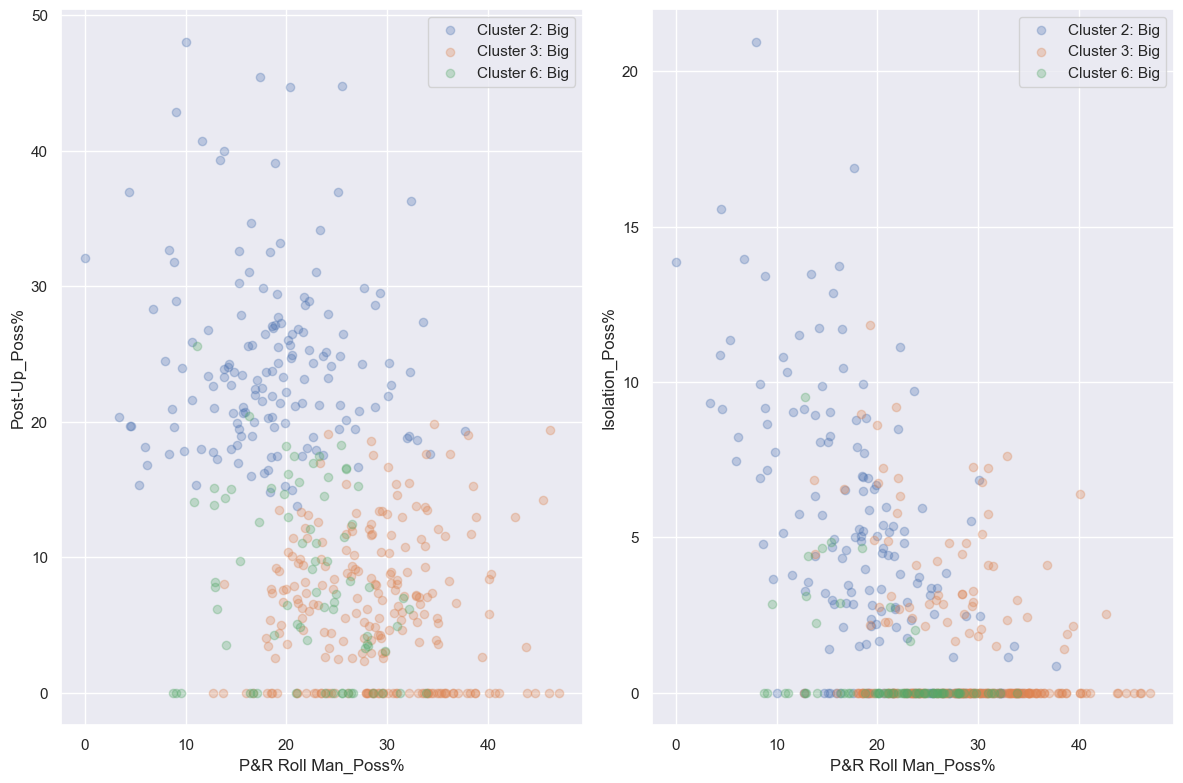

In [40]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

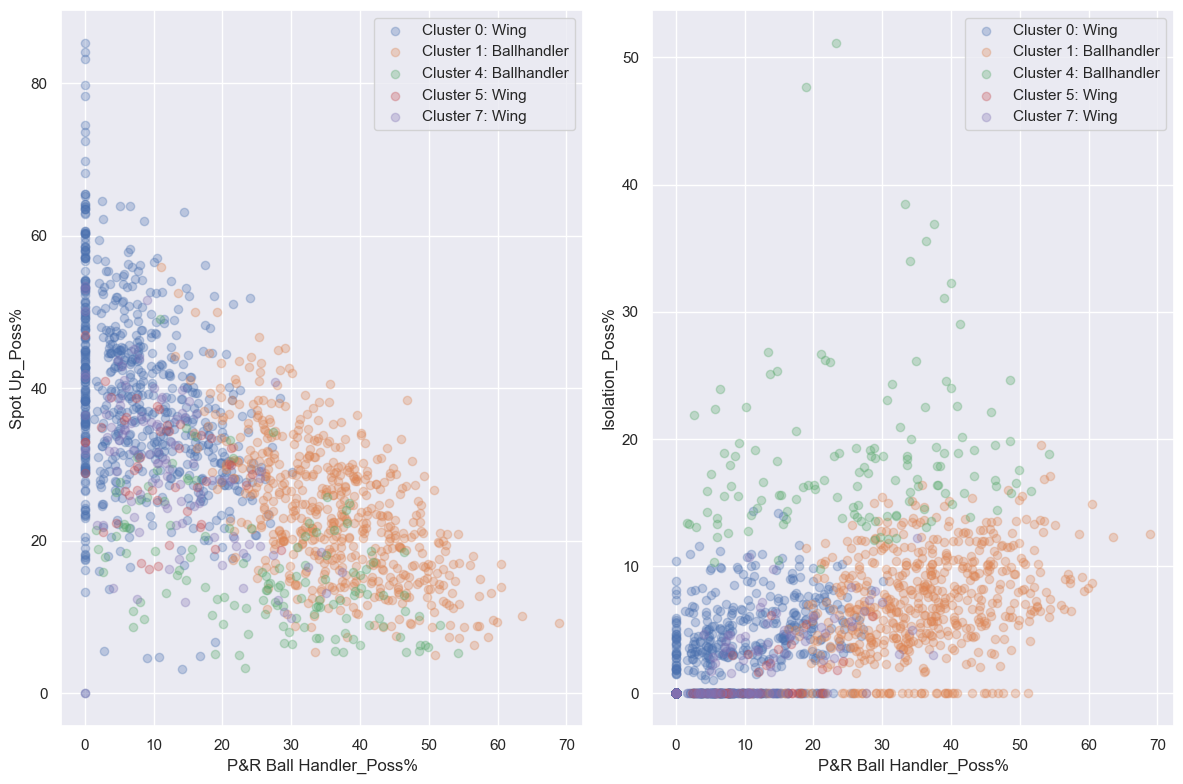

In [41]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

### Distributions

In [42]:
cluster_dict

{4: 'Ballhandler',
 1: 'Ballhandler',
 2: 'Big',
 6: 'Big',
 3: 'Big',
 7: 'Wing',
 5: 'Wing',
 0: 'Wing'}

In [43]:
cluster_order = [4, 1, 7, 5, 0, 3, 2, 6]

Height & Weight

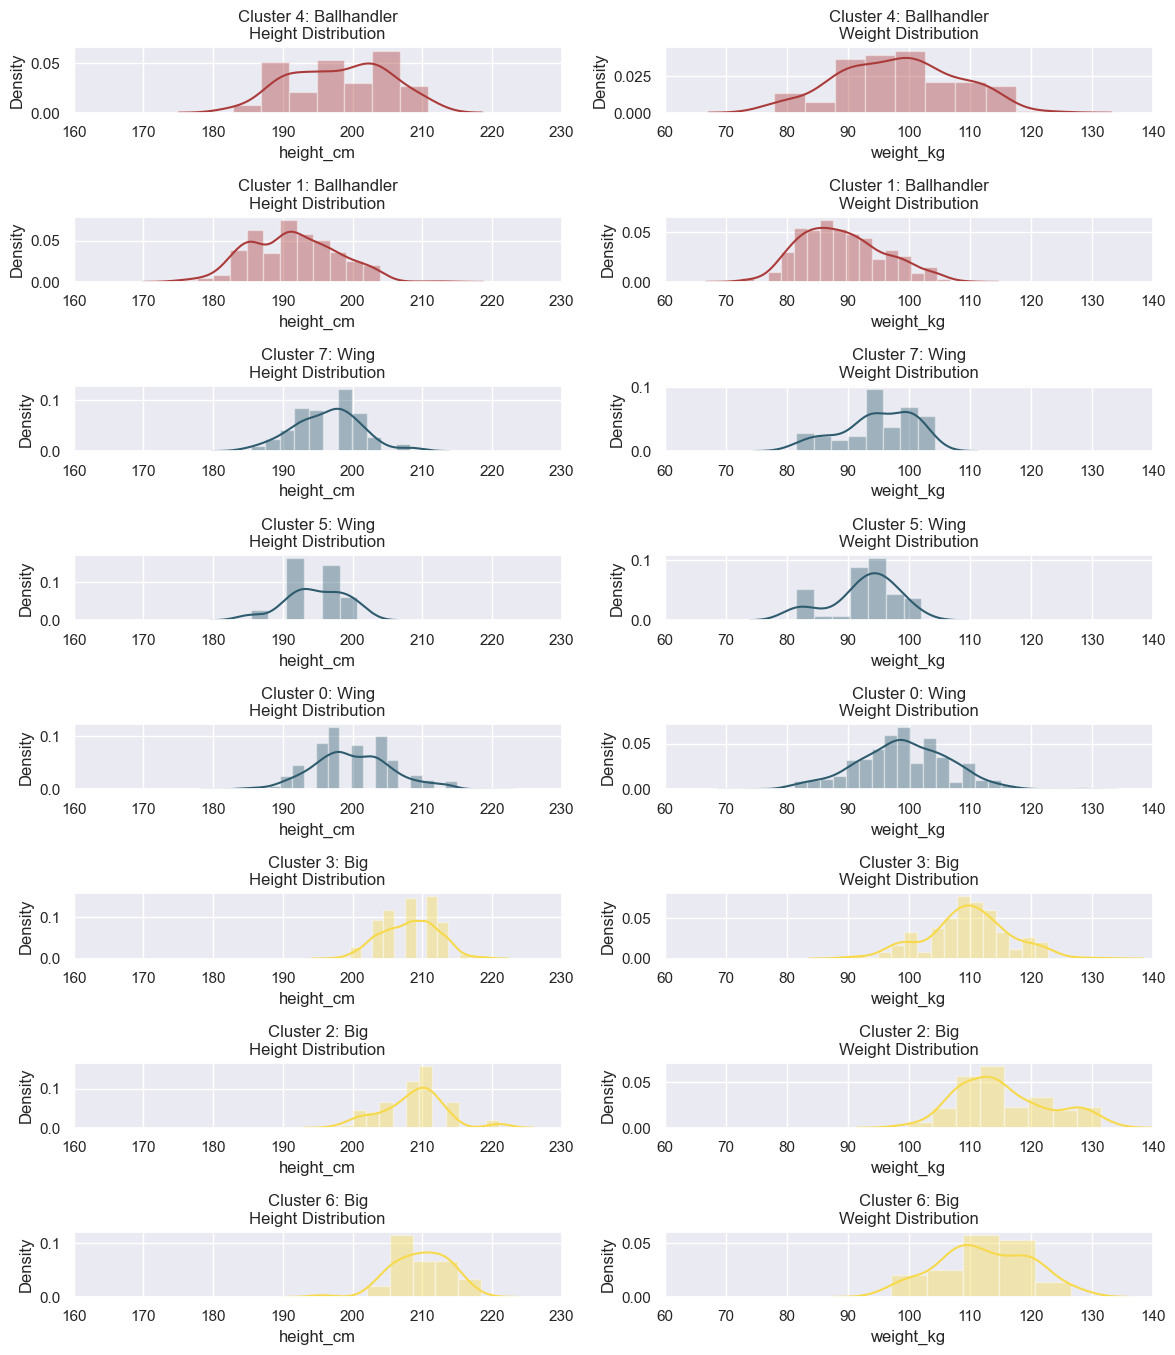

In [44]:
figsize(12, 20)
for idx, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, idx*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['height_cm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nHeight Distribution')
    plt.xlim(160, 230)
    plt.subplot(12, 2, idx*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['weight_kg'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nWeight Distribution')
    plt.xlim(60, 140)
plt.tight_layout()

Usage & OBPM

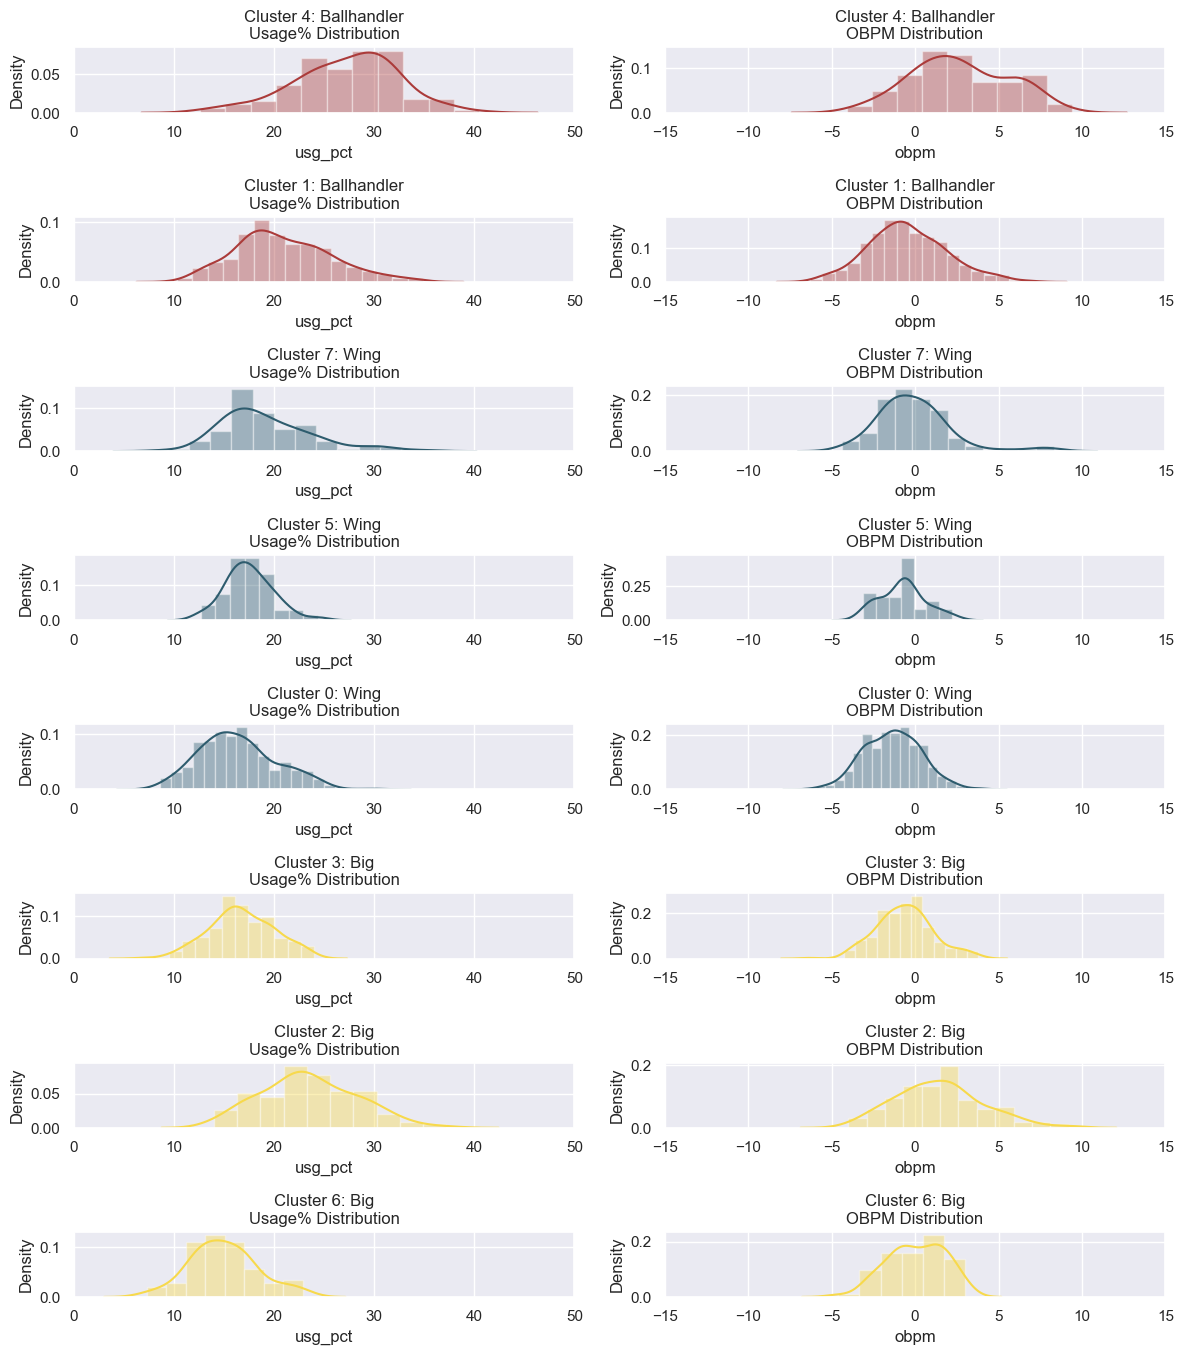

In [45]:
figsize(12, 20)
for i, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['usg_pct'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nUsage% Distribution')
    plt.xlim(0, 50)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['obpm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nOBPM Distribution')
    plt.xlim(-15, 15)
plt.tight_layout()

### Top & Bottom Players by Cluster

In [46]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'mp', 'obpm']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('obpm', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('obpm')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

Ballhandlers

In [48]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 133


Best 10 Players     Season                    Team    mp  obpm  \
0           James Harden  2018-2019         Houston Rockets  2867   9.4   
1           James Harden  2017-2018         Houston Rockets  2551   8.5   
2         Damian Lillard  2019-2020  Portland Trail Blazers  2474   8.3   
3           James Harden  2019-2020         Houston Rockets  2483   8.1   
4  Giannis Antetokounmpo  2021-2022         Milwaukee Bucks  2204   7.6   
5         Damian Lillard  2020-2021  Portland Trail Blazers  2398   7.5   
6  Giannis Antetokounmpo  2019-2020         Milwaukee Bucks  1917   7.4   
7            Luka Doncic  2019-2020        Dallas Mavericks  2047   7.4   
8           LeBron James  2017-2018     Cleveland Cavaliers  3026   7.3   
9         Damian Lillard  2017-2018  Portland Trail Blazers  2670   7.0   

  Worst 10 Players     Season                Team    mp  obpm  
0    Austin Rivers  2018-2019  Washington Wizards   683  -4.1  
1    Austin Rivers  2021-2022      Denver Nuggets  1480  -3.5  
2    Austin Rivers  2018-2019     Houston Rockets  1345  -2.9  
3    Austin Rivers  2020-2021     New York Knicks   442  -2.4  
4    James Johnson  2018-2019          Miami Heat  1164  -2.4  
5      Jeff Teague  2020-2021      Boston Celtics   616  -2.4  
6     Dion Waiters  2017-2018          Miami Heat   918  -2.1  
7    Austin Rivers  2019-2020     Houston Rockets  1594  -2.1  
8    Malachi Flynn  2021-2022     Toronto Raptors   537  -1.8  
9   Brandon Ingram  2018-2019  Los Angeles Lakers  1760  -1.3

In [49]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 569


Best 10 Players     Season                    Team    mp  obpm  \
0      Trae Young  2021-2022           Atlanta Hawks  2652   7.1   
1    Kyrie Irving  2019-2020           Brooklyn Nets   658   6.7   
2      Trae Young  2019-2020           Atlanta Hawks  2120   6.2   
3       Ja Morant  2021-2022       Memphis Grizzlies  1889   6.2   
4    Jimmy Butler  2020-2021              Miami Heat  1745   5.4   
5     CJ McCollum  2021-2022    New Orleans Pelicans   878   5.3   
6      Trae Young  2020-2021           Atlanta Hawks  2125   5.3   
7    Bradley Beal  2019-2020      Washington Wizards  2053   5.3   
8    Kemba Walker  2018-2019       Charlotte Hornets  2863   5.2   
9     CJ McCollum  2020-2021  Portland Trail Blazers  1600   5.0   

  Worst 10 Players     Season                    Team    mp  obpm  
0    Killian Hayes  2020-2021         Detroit Pistons   670  -6.3  
1  Justise Winslow  2020-2021       Memphis Grizzlies   507  -6.2  
2      Jacob Evans  2019-2020   Golden State Warriors   414  -5.7  
3   Tyrone Wallace  2018-2019    Los Angeles Clippers   628  -5.6  
4      Jawun Evans  2017-2018    Los Angeles Clippers   778  -5.4  
5   Isaiah Briscoe  2018-2019           Orlando Magic   559  -5.4  
6       Jeremy Lin  2018-2019         Toronto Raptors   433  -5.4  
7      Rodney Hood  2020-2021  Portland Trail Blazers   726  -5.3  
8      Jalen Suggs  2021-2022           Orlando Magic  1307  -5.3  
9  Jerome Robinson  2019-2020    Los Angeles Clippers   476  -5.3

Bigs

In [50]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 152


Best 10 Players     Season                    Team    mp  obpm  \
0        Nikola Jokic  2021-2022          Denver Nuggets  2476   9.2   
1        Nikola Jokic  2020-2021          Denver Nuggets  2488   9.1   
2         Joel Embiid  2021-2022      Philadelphia 76ers  2297   7.2   
3       Anthony Davis  2018-2019    New Orleans Pelicans  1850   7.1   
4  Karl-Anthony Towns  2019-2020  Minnesota Timberwolves  1187   7.0   
5         Joel Embiid  2020-2021      Philadelphia 76ers  1585   6.3   
6        Nikola Jokic  2018-2019          Denver Nuggets  2504   6.2   
7     Zion Williamson  2020-2021    New Orleans Pelicans  2026   6.1   
8      Nikola Vucevic  2020-2021           Orlando Magic  1500   5.5   
9        Nikola Jokic  2019-2020          Denver Nuggets  2336   5.5   

   Worst 10 Players     Season                   Team   mp  obpm  
0     James Wiseman  2020-2021  Golden State Warriors  836  -4.0  
1       Greg Monroe  2018-2019        Toronto Raptors  423  -3.5  
2       Harry Giles  2018-2019       Sacramento Kings  820  -3.4  
3       Joe Johnson  2017-2018        Houston Rockets  505  -3.3  
4       Robin Lopez  2019-2020        Milwaukee Bucks  958  -3.0  
5  DeMarcus Cousins  2021-2022         Denver Nuggets  431  -2.8  
6    Andre Drummond  2020-2021     Los Angeles Lakers  520  -2.7  
7     Dirk Nowitzki  2018-2019       Dallas Mavericks  795  -2.7  
8       Robin Lopez  2021-2022          Orlando Magic  612  -2.4  
9      JaVale McGee  2020-2021    Cleveland Cavaliers  503  -2.3

In [51]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 74


Best 10 Players     Season                    Team    mp  obpm  \
0          Rudy Gobert  2018-2019               Utah Jazz  2577   3.0   
1          Rudy Gobert  2021-2022               Utah Jazz  2120   2.9   
2  Robert Williams III  2020-2021          Boston Celtics   985   2.9   
3         Clint Capela  2020-2021           Atlanta Hawks  1898   2.7   
4        Jarrett Allen  2021-2022     Cleveland Cavaliers  1809   2.7   
5  Robert Williams III  2021-2022          Boston Celtics  1804   2.4   
6         Clint Capela  2021-2022           Atlanta Hawks  2042   2.2   
7       DeAndre Jordan  2018-2019         New York Knicks   493   2.2   
8         Terry Taylor  2021-2022          Indiana Pacers   714   2.2   
9          Enes Kanter  2020-2021  Portland Trail Blazers  1758   2.1   

  Worst 10 Players     Season                Team    mp  obpm  
0      Ian Mahinmi  2017-2018  Washington Wizards  1145  -4.6  
1     Nerlens Noel  2021-2022     New York Knicks   562  -3.1  
2   Daniel Gafford  2019-2020       Chicago Bulls   609  -2.8  
3    Zaza Pachulia  2018-2019     Detroit Pistons   878  -2.8  
4   Tyson Chandler  2018-2019  Los Angeles Lakers   786  -2.7  
5   Isaiah Stewart  2021-2022     Detroit Pistons  1816  -2.5  
6       Khem Birch  2019-2020       Orlando Magic   922  -2.5  
7     Nerlens Noel  2020-2021     New York Knicks  1547  -2.4  
8   Onyeka Okongwu  2020-2021       Atlanta Hawks   601  -2.2  
9    Dwight Howard  2020-2021  Philadelphia 76ers  1196  -2.1

In [52]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 224


Best 10 Players     Season                   Team    mp  obpm  \
0    Mike Muscala  2021-2022  Oklahoma City Thunder   592   3.8   
1    John Collins  2019-2020          Atlanta Hawks  1363   3.7   
2  Christian Wood  2019-2020        Detroit Pistons  1325   3.5   
3      Al Horford  2018-2019         Boston Celtics  1973   3.3   
4    Clint Capela  2018-2019        Houston Rockets  2249   3.3   
5  Brandon Clarke  2021-2022      Memphis Grizzlies  1246   3.1   
6   Thomas Bryant  2019-2020     Washington Wizards  1147   2.9   
7     Bam Adebayo  2020-2021             Miami Heat  2143   2.9   
8     Jalen Smith  2021-2022         Indiana Pacers   543   2.9   
9   Chris Boucher  2020-2021        Toronto Raptors  1453   2.7   

   Worst 10 Players     Season                   Team    mp  obpm  
0    Dewayne Dedmon  2019-2020       Sacramento Kings   541  -6.3  
1  Anzejs Pasecniks  2019-2020     Washington Wizards   437  -4.1  
2      Goga Bitadze  2019-2020         Indiana Pacers   471  -4.1  
3     Moritz Wagner  2018-2019     Los Angeles Lakers   446  -3.9  
4       Tarik Black  2017-2018        Houston Rockets   536  -3.7  
5       Isaiah Roby  2020-2021  Oklahoma City Thunder  1425  -3.7  
6     Miles Plumlee  2017-2018          Atlanta Hawks   918  -3.7  
7       Aron Baynes  2017-2018         Boston Celtics  1485  -3.6  
8      Kosta Koufos  2018-2019       Sacramento Kings   502  -3.6  
9  Precious Achiuwa  2020-2021             Miami Heat   737  -3.6

Wings

In [53]:
c = 7
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 102


Best 10 Players     Season                   Team    mp  obpm  \
0      Stephen Curry  2020-2021  Golden State Warriors  2152   8.3   
1      Stephen Curry  2017-2018  Golden State Warriors  1631   7.8   
2      Stephen Curry  2018-2019  Golden State Warriors  2331   7.1   
3      Stephen Curry  2021-2022  Golden State Warriors  2211   5.4   
4        Paul George  2019-2020   Los Angeles Clippers  1419   3.8   
5  Bogdan Bogdanovic  2020-2021          Atlanta Hawks  1305   3.3   
6      Davis Bertans  2019-2020     Washington Wizards  1583   2.7   
7      Klay Thompson  2021-2022  Golden State Warriors   941   2.6   
8        Buddy Hield  2019-2020       Sacramento Kings  2216   2.5   
9          JJ Redick  2019-2020   New Orleans Pelicans  1581   2.3   

  Worst 10 Players     Season                   Team    mp  obpm  
0     Jordan Poole  2019-2020  Golden State Warriors  1274  -4.4  
1   Svi Mykhailiuk  2018-2019     Los Angeles Lakers   420  -4.1  
2      Gary Harris  2020-2021          Orlando Magic   499  -3.6  
3     Ben McLemore  2020-2021        Houston Rockets   537  -3.4  
4   Justin Holiday  2018-2019      Memphis Grizzlies  1282  -3.3  
5         CJ Miles  2018-2019        Toronto Raptors   562  -3.2  
6     Ben McLemore  2017-2018      Memphis Grizzlies  1091  -2.9  
7    Nicolas Batum  2019-2020      Charlotte Hornets   505  -2.8  
8    Davis Bertans  2021-2022     Washington Wizards   501  -2.5  
9       Damion Lee  2021-2022  Golden State Warriors  1256  -2.4

In [54]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 46


Best 10 Players     Season                Team    mp  obpm  \
0        JJ Redick  2018-2019  Philadelphia 76ers  2379   2.2   
1        JJ Redick  2017-2018  Philadelphia 76ers  2116   2.2   
2  Duncan Robinson  2019-2020          Miami Heat  2166   1.5   
3   Doug McDermott  2020-2021      Indiana Pacers  1619   1.4   
4  Wayne Ellington  2020-2021     Detroit Pistons  1012   1.1   
5      Gary Harris  2017-2018      Denver Nuggets  2304   1.0   
6  Wayne Ellington  2017-2018          Miami Heat  2041   1.0   
7   Reggie Bullock  2017-2018     Detroit Pistons  1732   0.7   
8    Evan Fournier  2020-2021      Boston Celtics   472   0.1   
9  Marco Belinelli  2017-2018  Philadelphia 76ers   737   0.0   

   Worst 10 Players     Season              Team    mp  obpm  
0      Allen Crabbe  2019-2020     Atlanta Hawks   522  -3.1  
1     Avery Bradley  2017-2018   Detroit Pistons  1268  -2.8  
2       Gary Harris  2019-2020    Denver Nuggets  1780  -2.8  
3  Ignas Brazdeikis  2021-2022     Orlando Magic   536  -2.7  
4     Armoni Brooks  2021-2022   Houston Rockets   690  -2.6  
5    Justin Holiday  2021-2022  Sacramento Kings   641  -2.6  
6     Terrence Ross  2021-2022     Orlando Magic  1448  -2.5  
7       Gary Harris  2020-2021    Denver Nuggets   581  -2.2  
8       James Ennis  2017-2018   Detroit Pistons   551  -2.2  
9   Rodney McGruder  2018-2019        Miami Heat  1550  -2.2

In [55]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 673


Best 10 Players     Season                   Team    mp  obpm  \
0    Danilo Gallinari  2019-2020  Oklahoma City Thunder  1834   4.1   
1  Michael Porter Jr.  2020-2021         Denver Nuggets  1912   4.0   
2         Buddy Hield  2018-2019       Sacramento Kings  2615   3.5   
3        Jaylen Brown  2020-2021         Boston Celtics  1999   3.2   
4        Kelly Olynyk  2020-2021        Houston Rockets   840   2.9   
5        John Collins  2018-2019          Atlanta Hawks  1829   2.8   
6     Otto Porter Jr.  2017-2018     Washington Wizards  2432   2.6   
7        Desmond Bane  2021-2022      Memphis Grizzlies  2266   2.5   
8          Jeff Green  2019-2020        Houston Rockets   407   2.5   
9       Mikal Bridges  2020-2021           Phoenix Suns  2348   2.4   

  Worst 10 Players     Season                Team   mp  obpm  
0        KZ Okpala  2020-2021          Miami Heat  447  -6.5  
1     Dwayne Bacon  2019-2020   Charlotte Hornets  687  -5.9  
2      Isaac Bonga  2020-2021  Washington Wizards  432  -5.8  
3      Paul Zipser  2017-2018       Chicago Bulls  824  -5.5  
4      Abdel Nader  2017-2018      Boston Celtics  522  -5.5  
5  Sekou Doumbouya  2020-2021     Detroit Pistons  869  -5.4  
6        PJ Tucker  2020-2021     Houston Rockets  959  -5.3  
7  Sekou Doumbouya  2019-2020     Detroit Pistons  754  -5.2  
8    Kent Bazemore  2021-2022  Los Angeles Lakers  545  -5.1  
9     Brandon Paul  2017-2018   San Antonio Spurs  576  -5.1

### Edge Cases

In [56]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

Player player_cluster        player_cluster_adj  n_cluster
87     Christian Wood      {0, 3, 4}  {Ballhandler, Big, Wing}          3
110  Danilo Gallinari      {0, 2, 4}  {Ballhandler, Big, Wing}          3
132  DeMarcus Cousins      {0, 2, 4}  {Ballhandler, Big, Wing}          3
218   Harrison Barnes      {0, 2, 4}  {Ballhandler, Big, Wing}          3
286      Jerami Grant      {0, 3, 4}  {Ballhandler, Big, Wing}          3

In [57]:
temp[(temp['n_cluster'] == 2) & 
     (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

Player player_cluster  player_cluster_adj  n_cluster
76      Carmelo Anthony         {2, 4}  {Ballhandler, Big}          2
336       Julius Randle         {2, 4}  {Ballhandler, Big}          2
344  Karl-Anthony Towns         {2, 4}  {Ballhandler, Big}          2

In [63]:
df[df['Player'] == 'Christian Wood']\
[['Player', 'Team', 'Season', 'mp'] + weights + 
 ['player_cluster', 'silhouette_coefficient']]

Player             Team     Season    mp  Isolation_Poss%  \
451   Christian Wood  Detroit Pistons  2019-2020  1325         0.057692   
565   Christian Wood  Houston Rockets  2020-2021  1326         0.104000   
1691  Christian Wood  Houston Rockets  2021-2022  2094         0.133147   

      P&R Ball Handler_Poss%  Post-Up_Poss%  P&R Roll Man_Poss%  \
451                 0.000000       0.073718            0.219551   
565                 0.000000       0.089333            0.224000   
1691                0.019553       0.103352            0.181564   

      Spot Up_Poss%  Off Screen_Poss%  Hand Off_Poss%  Cut_Poss%  \
451        0.240385          0.000000         0.00000   0.107372   
565        0.230667          0.033333         0.00000   0.096000   
1691       0.189013          0.054004         0.01676   0.093110   

      Offensive Rebounds_Poss%  Transition_Poss%  Catch and Shoot_FGA%  \
451                   0.115385          0.185897              0.248521   
565                   0.066667          0.156000              0.303125   
1691                  0.071695          0.137803              0.313636   

      At Rim_FGA%  Long (3 point jump shots)_FGA%  \
451      0.570020                        0.276134   
565      0.453125                        0.318750   
1691     0.450000                        0.381818   

      All Jump Shots off the Dribble_FGA%  \
451                              0.055227   
565                              0.109375   
1691                             0.126136   

      Pick and Rolls Including Passes_On_Court%  \
451                                    0.000000   
565                                    0.004697   
1691                                   0.006860   

      Isolations Including Passes_On_Court%  \
451                                0.014521   
565                                0.031792   
1691                               0.037960   

      Post-Ups Including Passes_On_Court%  player_cluster  \
451                              0.020801               3   
565                              0.032153               0   
1691                             0.034301               4   

      silhouette_coefficient  
451                 0.071999  
565                -0.113385  
1691                0.091646

## Visualization via TSNE

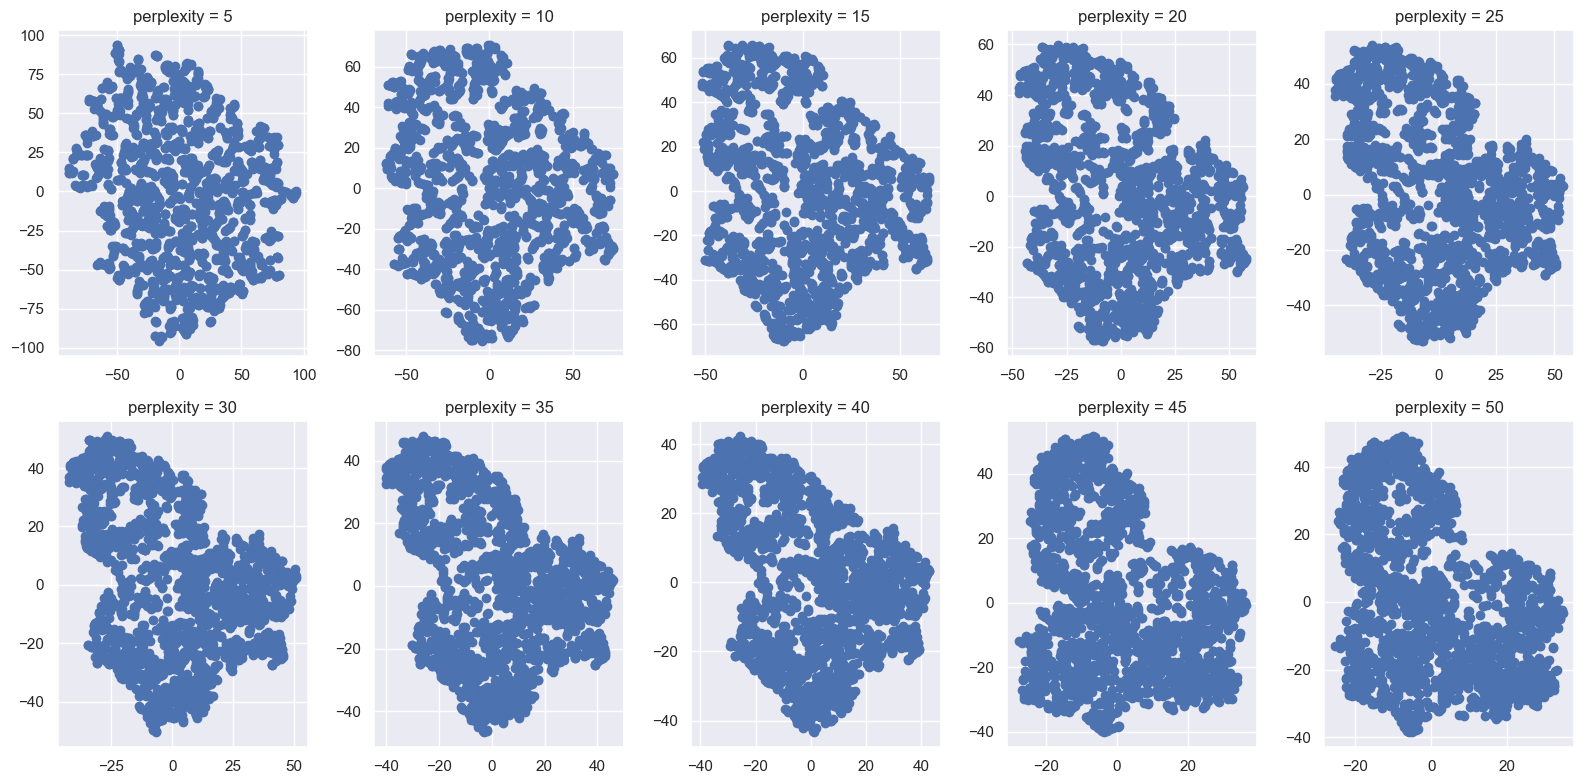

In [64]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [67]:
perplexity = 25
tsne = TSNE(perplexity=perplexity, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

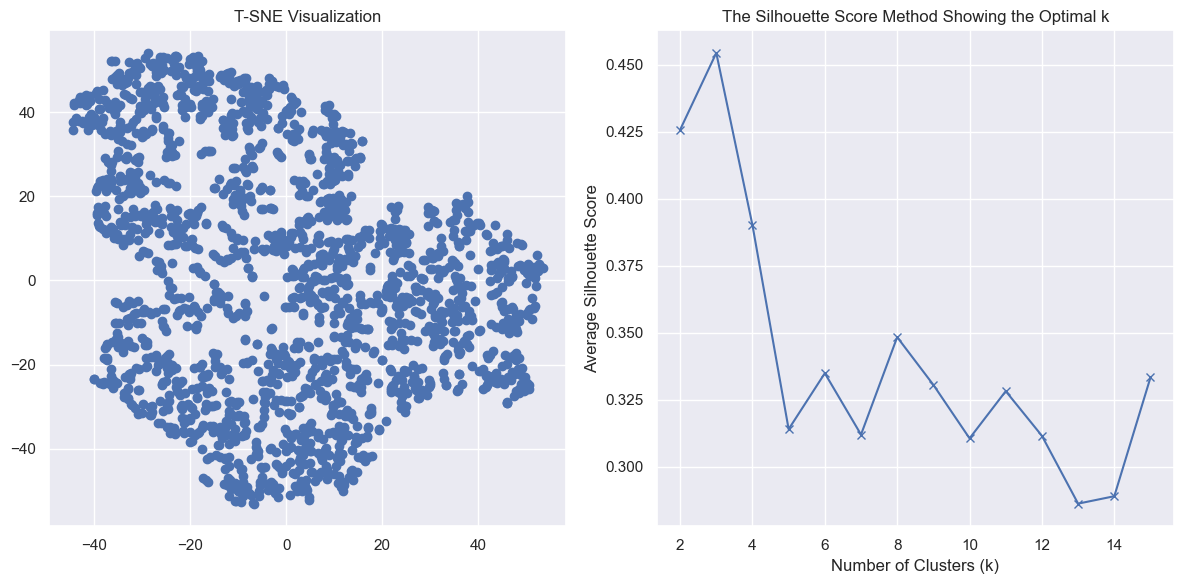

In [68]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [80]:
df_tsne = df.copy()
n_clusters_tsne = 8

sc_tsne = SpectralClustering(n_clusters=n_clusters_tsne, 
                             affinity='nearest_neighbors', 
                             random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

In [81]:
upper_limit = 100
lower_limit = -60
loc = 'upper right'

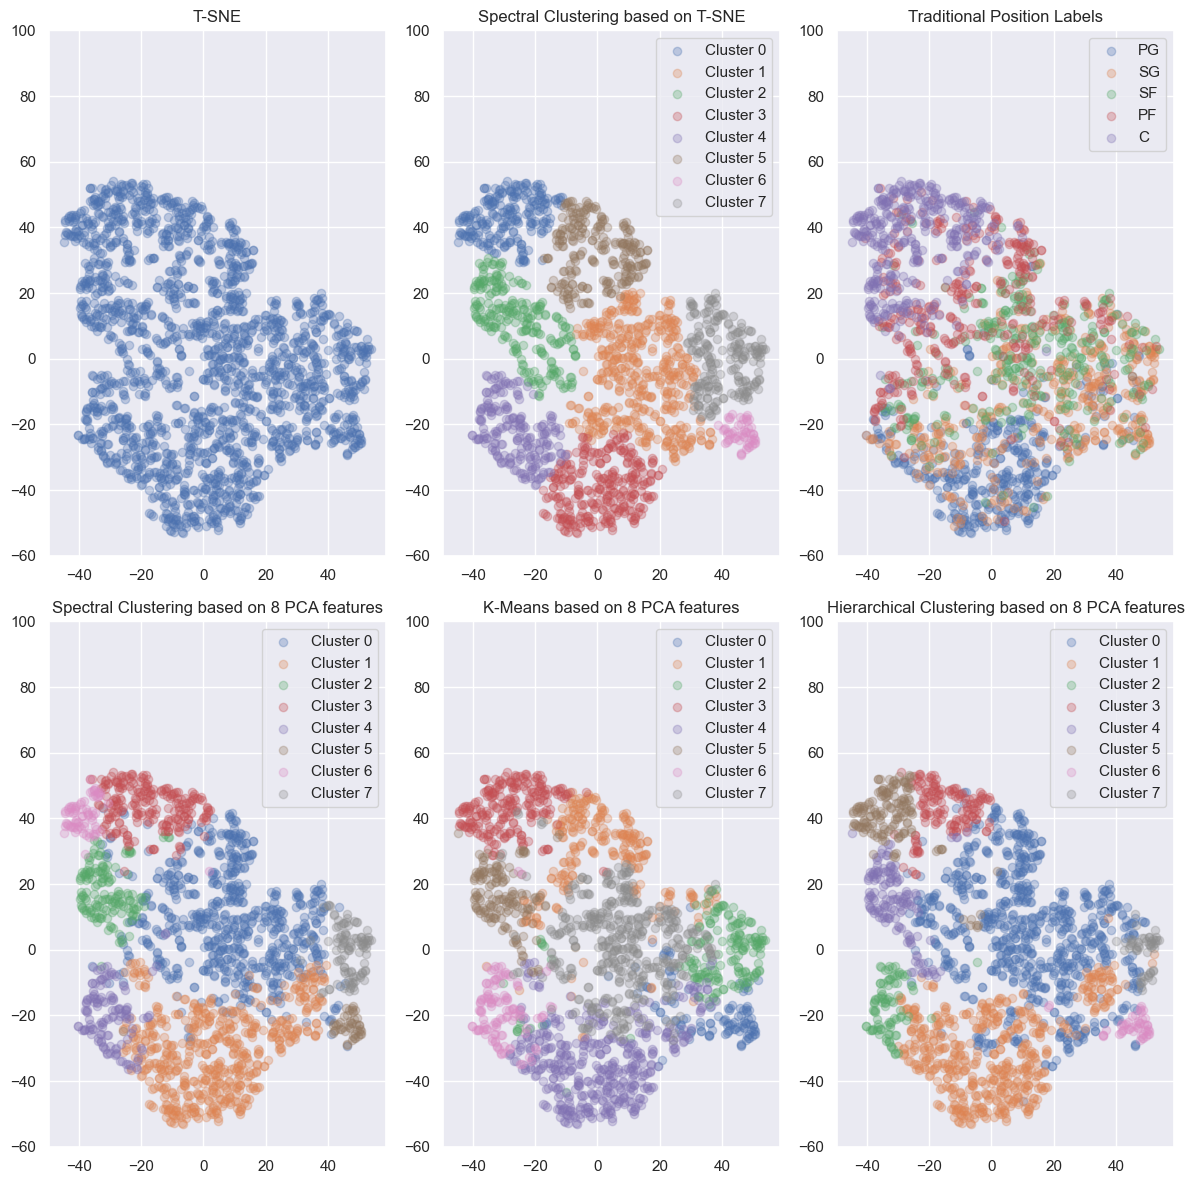

In [82]:
figsize(12, 12)

plt.subplot(2, 3, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')
plt.ylim(lower_limit, upper_limit)

plt.subplot(2, 3, 2)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(2, 3, 3)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Traditional Position Labels')

plt.subplot(2, 3, 4)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

plt.subplot(2, 3, 5)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'K-Means based on {n_components} PCA features')

plt.subplot(2, 3, 6)
agc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                              linkage='ward')
labels = agc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Hierarchical Clustering based on {n_components} PCA features')

plt.tight_layout()

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features')

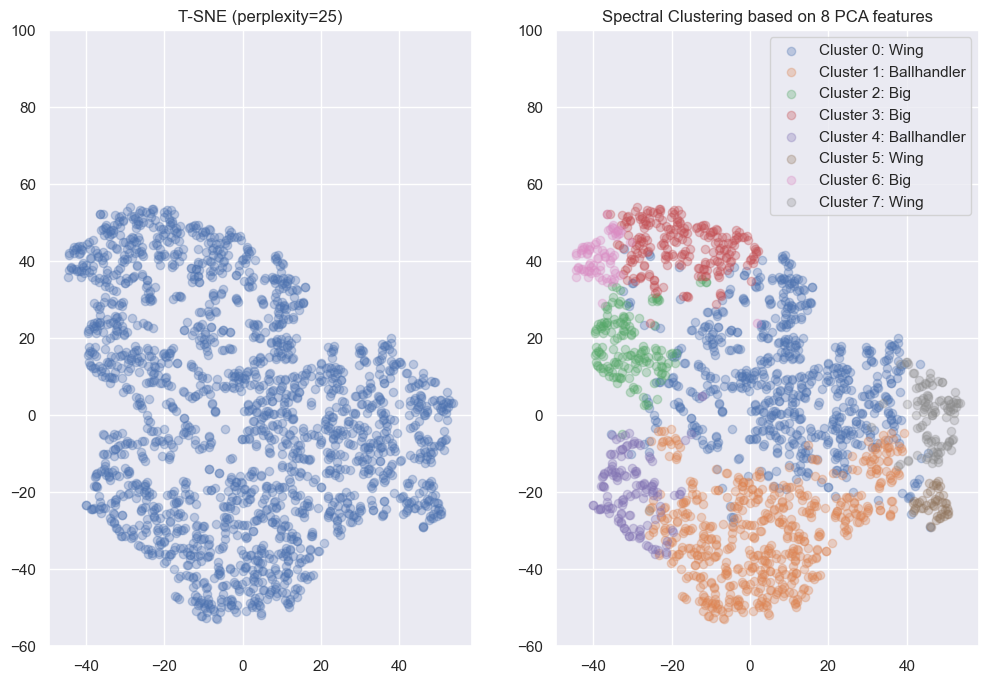

In [83]:
figsize(12, 8)

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title(f'T-SNE (perplexity={perplexity})')
plt.ylim(lower_limit, upper_limit)

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features')

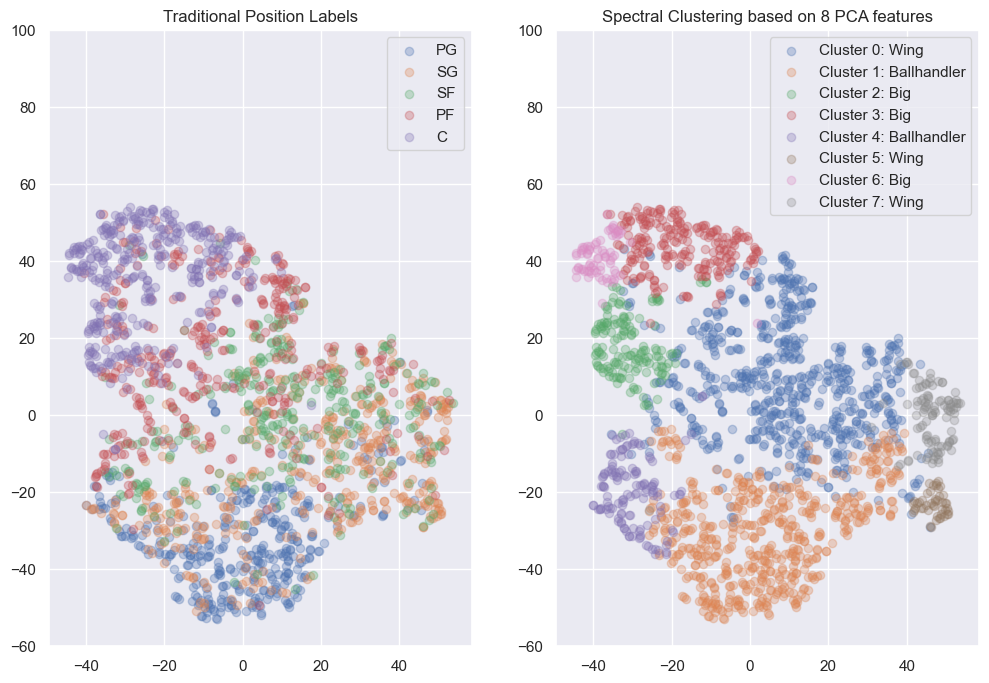

In [84]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Traditional Position Labels')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features')

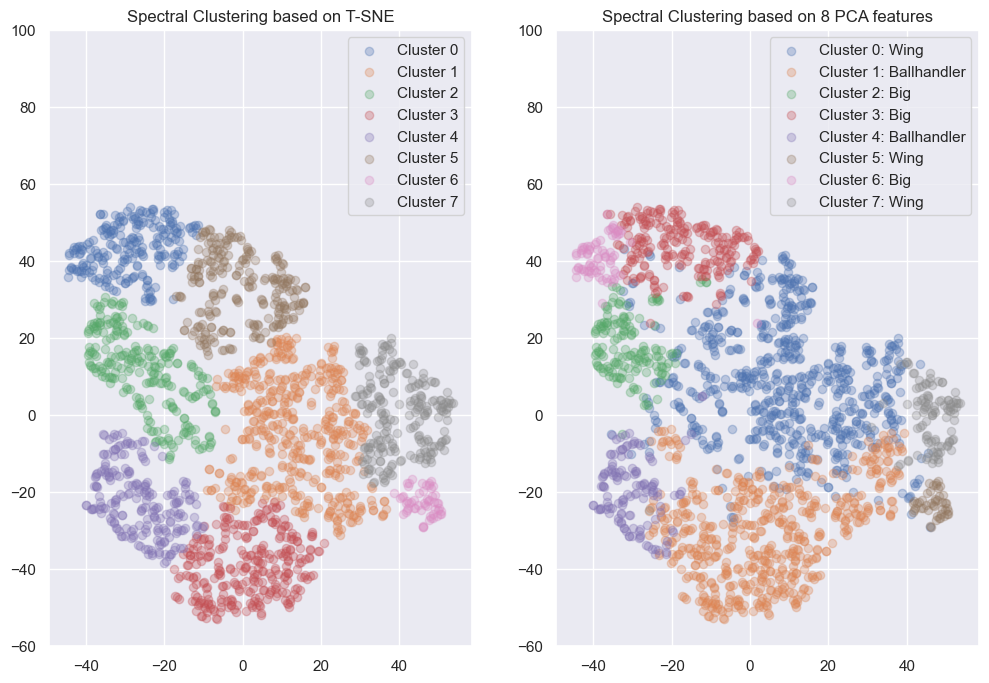

In [85]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')